## Retrieve and Explore Stock Trading Data

Mucun Tian

In this notebook, we are going to explore stock trading data. 

Two data sets are used
- one is a "company list" dataset downloaded from <a href=http://www.nasdaq.com/screening/company-list.aspx>NASDAQ Company List</a>.

- the other one is the Google finance dataset obtained by URL https://www.google.com/finance/historical?output=csv&q=GOOG (replace `GOOG` with the ticker symbol)

The goal of this notebook is to learn how to analyze time serial data and to predict future stock price and/or trend (rise or fall).

### Load libraries

In [1]:
library(tidyverse)
library(stringr)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats


In [2]:
options(repr.matrix.max.rows=10,
        repr.plot.width=10,
        repr.plot.height=3)

### Load data

In order to get stock trading data for each stock, we first need ticker symbol information.

So three .csv files are downloaded from <a href=http://www.nasdaq.com/screening/company-list.aspx>NASDAQ Company List</a>. They are named: `nasdaq_companylist.csv`, `amex_companylist.csv` and `nyse_companylist.csv` respectively.

These three files store metadata for each stock, including: Symbol, Company Name, LastSale, MarketCap, IPO year, Sector, Industry and one empty column.
- `nasdaq_companylist.csv` includes stocks in NASDAQ Exchange and some of records in this file are also in the other two files.
- `amex_companylist.csv` includes stocks in AMEX Exchange
- `nyse_companylist.csv` includes stocks in NYSE Exchange

Missing values are represented either by blank cells or by "n/a" in original files.

Read files, and remove the empty column and the duplicate records between `nasdaq_companylist.csv` and `amex_companylist.csv` or `nyse_companylist.csv`

In [3]:
nasdaq = suppressWarnings(read_csv("./nasdaq_companylist.csv",
                  col_types = "ccdcicc_")) 

amex = suppressWarnings(read_csv("./amex_companylist.csv",
                col_types = "ccdcicc_"))

nyse = suppressWarnings(read_csv("./nyse_companylist.csv", 
                col_types = "ccdcicc_"))

nasdaq = nasdaq %>%
    select(Symbol) %>%
    anti_join(amex %>% select(Symbol)) %>%
    anti_join(nyse %>% select(Symbol)) %>%
    inner_join(nasdaq)

stock.ticker.symbols = bind_rows(NASDAQ = nasdaq,
                                 AMEX = amex,
                                 NYSE = nyse,
                                 .id = "Exchange")
stock.ticker.symbols

Joining, by = "Symbol"
Joining, by = "Symbol"
Joining, by = "Symbol"


Exchange,Symbol,Name,LastSale,MarketCap,IPOyear,Sector,industry
NASDAQ,PIH,"1347 Property Insurance Holdings, Inc.",7.225,$43.24M,2014,Finance,Property-Casualty Insurers
NASDAQ,TURN,180 Degree Capital Corp.,2.058,$64.05M,NA,Finance,Finance/Investors Services
NASDAQ,FLWS,"1-800 FLOWERS.COM, Inc.",9.550,$617.16M,1999,Consumer Services,Other Specialty Stores
NASDAQ,FCCY,1st Constitution Bancorp (NJ),18.350,$148.14M,NA,Finance,Savings Institutions
NASDAQ,SRCE,1st Source Corporation,50.030,$1.3B,NA,Finance,Major Banks
...,...,...,...,...,...,...,...
NYSE,ZBK,Zions Bancorporation,29.4844,n/a,NA,Finance,Major Banks
NYSE,ZOES,"Zoe&#39;s Kitchen, Inc.",13.3700,$261.45M,2014,Consumer Services,Restaurants
NYSE,ZTS,Zoetis Inc.,71.2900,$34.74B,2013,Health Care,Major Pharmaceuticals
NYSE,ZTO,ZTO Express (Cayman) Inc.,16.4700,$11.82B,2016,Transportation,Trucking Freight/Courier Services


Check duplicate symbols

In [4]:
stock.ticker.symbols %>%
    group_by(Symbol) %>%
    summarize(count = n()) %>%
    ungroup() %>%
    filter(count > 1)

Symbol,count


Since `MarketCap` in original files is charactor type, we are going to convert it to numeric type by extracting number and using unit million.
- The number is extracted by digits `[:digit:]` and dot `.` 
- If a `MarketCap` cell ends with "B", multiply the extracted number by 1000; otherwise keep it unchanged.

In [5]:
stock.ticker.symbols = stock.ticker.symbols %>%
    mutate(MarketCap = ifelse(stringr::str_detect(MarketCap, "B"), 
                                 as.numeric(str_extract(MarketCap, "[[:digit:].]+")) * 1000, 
                                 as.numeric(str_extract(MarketCap, "[[:digit:].]+"))))
head(stock.ticker.symbols)

Exchange,Symbol,Name,LastSale,MarketCap,IPOyear,Sector,industry
NASDAQ,PIH,"1347 Property Insurance Holdings, Inc.",7.225,43.24,2014,Finance,Property-Casualty Insurers
NASDAQ,TURN,180 Degree Capital Corp.,2.058,64.05,NA,Finance,Finance/Investors Services
NASDAQ,FLWS,"1-800 FLOWERS.COM, Inc.",9.550,617.16,1999,Consumer Services,Other Specialty Stores
NASDAQ,FCCY,1st Constitution Bancorp (NJ),18.350,148.14,NA,Finance,Savings Institutions
NASDAQ,SRCE,1st Source Corporation,50.030,1300.00,NA,Finance,Major Banks
NASDAQ,VNET,"21Vianet Group, Inc.",7.240,814.50,2011,Technology,"Computer Software: Programming, Data Processing"


Change "n/a" in Sector and industry to "Others"

In [6]:
stock.ticker.symbols = stock.ticker.symbols %>%
    mutate(Sector = ifelse(Sector=="n/a", "Others", Sector),
           industry = ifelse(industry=="n/a", "Others", industry))

Write to csv

In [7]:
write_csv(stock.ticker.symbols, "./stock_ticker_symbols.csv")

In [8]:
stock.ticker.symbols = read_csv("./stock_ticker_symbols.csv")
stock.ticker.symbols

Parsed with column specification:
cols(
  Exchange = col_character(),
  Symbol = col_character(),
  Name = col_character(),
  LastSale = col_double(),
  MarketCap = col_double(),
  IPOyear = col_integer(),
  Sector = col_character(),
  industry = col_character()
)


Exchange,Symbol,Name,LastSale,MarketCap,IPOyear,Sector,industry
NASDAQ,PIH,"1347 Property Insurance Holdings, Inc.",7.225,43.24,2014,Finance,Property-Casualty Insurers
NASDAQ,TURN,180 Degree Capital Corp.,2.058,64.05,NA,Finance,Finance/Investors Services
NASDAQ,FLWS,"1-800 FLOWERS.COM, Inc.",9.550,617.16,1999,Consumer Services,Other Specialty Stores
NASDAQ,FCCY,1st Constitution Bancorp (NJ),18.350,148.14,NA,Finance,Savings Institutions
NASDAQ,SRCE,1st Source Corporation,50.030,1300.00,NA,Finance,Major Banks
...,...,...,...,...,...,...,...
NYSE,ZBK,Zions Bancorporation,29.4844,NA,NA,Finance,Major Banks
NYSE,ZOES,"Zoe&#39;s Kitchen, Inc.",13.3700,261.45,2014,Consumer Services,Restaurants
NYSE,ZTS,Zoetis Inc.,71.2900,34740.00,2013,Health Care,Major Pharmaceuticals
NYSE,ZTO,ZTO Express (Cayman) Inc.,16.4700,11820.00,2016,Transportation,Trucking Freight/Courier Services


### Stats

Look at the number of stocks in each exchange

In [9]:
summary(as.factor(stock.ticker.symbols$Exchange))

AMEX NASDAQ   NYSE 
   358   3262   3146

Sector

In [10]:
summary(as.factor(stock.ticker.symbols$Sector))

Basic Industries         Capital Goods     Consumer Durables 
                  329                   374                   146 
Consumer Non-Durables     Consumer Services                Energy 
                  241                   821                   318 
              Finance           Health Care         Miscellaneous 
                 1038                   813                   143 
               Others      Public Utilities            Technology 
                 1529                   275                   617 
       Transportation 
                  122

Check sectors which are not in either of the exchange

In [11]:
stock.ticker.symbols %>%
    group_by(Exchange, Sector) %>%
    summarize(Count = n()) %>%
    ungroup() %>%
    spread(Exchange, Count) %>%
    filter(is.na(AMEX) | is.na(NASDAQ) | is.na(NYSE))

Sector,AMEX,NASDAQ,NYSE


All of the three exchange have common stock sectors

Summary of quantative variables: LastSale, MarketCap and IPOyear

In [12]:
summary(stock.ticker.symbols %>% select(LastSale, MarketCap, IPOyear))

    LastSale          MarketCap           IPOyear    
 Min.   :   0.008   Min.   :     1.0   Min.   :1972  
 1st Qu.:   9.410   1st Qu.:   152.0   1st Qu.:2002  
 Median :  21.985   Median :   674.4   Median :2011  
 Mean   :  36.615   Mean   :  7235.4   Mean   :2007  
 3rd Qu.:  39.015   3rd Qu.:  3150.0   3rd Qu.:2015  
 Max.   :4320.000   Max.   :898350.0   Max.   :2017  
 NA's   :104        NA's   :1041       NA's   :3816  

Top 3 companies with largest market cap in each exchange

In [13]:
stock.ticker.symbols %>%
    group_by(Exchange) %>%
    top_n(3, MarketCap) %>%
    arrange(-MarketCap)

Exchange,Symbol,Name,LastSale,MarketCap,IPOyear,Sector,industry
NASDAQ,AAPL,Apple Inc.,174.97,898350,1980,Technology,Computer Manufacturing
NASDAQ,GOOGL,Alphabet Inc.,1056.61,734130,NA,Technology,"Computer Software: Programming, Data Processing"
NASDAQ,GOOG,Alphabet Inc.,1040.61,723020,2004,Technology,"Computer Software: Programming, Data Processing"
NYSE,BABA,Alibaba Group Holding Limited,191.19,489450,2014,Miscellaneous,Business Services
NYSE,JNJ,Johnson & Johnson,138.01,370770,NA,Health Care,Major Pharmaceuticals
NYSE,XOM,Exxon Mobil Corporation,81.42,344990,NA,Energy,Integrated oil Companies
AMEX,IMO,Imperial Oil Limited,31.16,26100,NA,Energy,Integrated oil Companies
AMEX,CQP,"Cheniere Energy Partners, LP",28.60,13840,2007,Public Utilities,Oil/Gas Transmission
AMEX,LNG,"Cheniere Energy, Inc.",47.96,11400,NA,Public Utilities,Oil/Gas Transmission


Since obtaining trading data for all the stocks is time-consuming due to the hit limit, we only select the top 5 stocks with the largest MarketCap in each sector for each exchange. 

In [14]:
stocks.selected = stock.ticker.symbols %>%
    group_by(Exchange, Sector) %>%
    top_n(5, MarketCap) %>%
    ungroup()
stocks.selected %>%
    nrow()

[1] 190

We are going to research these 190 stocks.

So far we only do an intially simply analysis for two stocks, we will keep gathering more data for final prediction tasks.

In [15]:
rthStock = 1
stock_trading_data = purrr::map_df(stocks.selected$Symbol, function(symbol) {
    address = sprintf("https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&apikey=H8VDYKQ0PNOMYSLI&datatype=csv&outputsize=full&symbol=%s", symbol)
    
    message("reading data from stock ", symbol)
    message((190 - rthStock), " stocks left")
    callNum = 1
    stockReceived = NULL
    hadError = TRUE
    while (hadError == TRUE) {
        hadError = tryCatch({
        stockReceived = suppressMessages(read_csv(address) %>%
            mutate(symbol = symbol) %>%
            filter(row_number() < 500))
        FALSE
    }, warning = function(warn) {
        if (callNum < 5) {
            callNum = callNum + 1
            return(TRUE)
        } else {
            callNum = 1
            return(FALSE)
        }
    }, error = function(err) {
        if (callNum < 5) {
            callNum = callNum + 1
            return(TRUE)
        } else {
            callNum = 1
            return(FALSE)
        }
        })
        message("pause 1 min")
        Sys.sleep(60)
    }
    rthStock = rthStock + 1 
    message("writing data to stock_trading.csv")
    if (!is.null(stockReceived)) {
        write_csv(stockReceived, "./stock_trading_raw.csv", append = TRUE)
    }
    message("writing data successfully")
    stockReceived
})
message("Task Done")

reading data from stock GOOG
189 stocks left
pause 1 min
writing data to stock_trading.csv
writing data successfully
reading data from stock GOOGL
189 stocks left
pause 1 min
writing data to stock_trading.csv
writing data successfully
reading data from stock AMZN
189 stocks left
pause 1 min
writing data to stock_trading.csv
writing data successfully
reading data from stock AAL
189 stocks left
pause 1 min
writing data to stock_trading.csv
writing data successfully
reading data from stock AMGN
189 stocks left
pause 1 min
writing data to stock_trading.csv
writing data successfully
reading data from stock AAPL
189 stocks left
pause 1 min
writing data to stock_trading.csv
writing data successfully
reading data from stock AY
189 stocks left
pause 1 min
writing data to stock_trading.csv
writing data successfully
reading data from stock CHRW
189 stocks left
pause 1 min
writing data to stock_trading.csv
writing data successfully
reading data from stock CASY
189 stocks left
pause 1 min
writing d

189 stocks left
pause 1 min
writing data to stock_trading.csv
writing data successfully
reading data from stock BGSF
189 stocks left
pause 1 min
writing data to stock_trading.csv
writing data successfully
reading data from stock BTX
189 stocks left
pause 1 min
writing data to stock_trading.csv
writing data successfully
reading data from stock BRG
189 stocks left
pause 1 min
writing data to stock_trading.csv
writing data successfully
reading data from stock ROX
189 stocks left
pause 1 min
writing data to stock_trading.csv
writing data successfully
reading data from stock CEF
189 stocks left
pause 1 min
writing data to stock_trading.csv
writing data successfully
reading data from stock CCF
189 stocks left
pause 1 min
writing data to stock_trading.csv
writing data successfully
reading data from stock CQH
189 stocks left
pause 1 min
writing data to stock_trading.csv
writing data successfully
reading data from stock CQP
189 stocks left
pause 1 min
writing data to stock_trading.csv
writing d

writing data successfully
reading data from stock C
189 stocks left
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 min
pause 1 

In [19]:
stock_trading_data = read_csv("./stock_trading_raw.csv", 
                              col_names = c("Date", "Open", "High", "Low", "Close", "Adjusted", "Volume", "Dividend", "SplitCoefficient", "Symbol"),
                              col_types = 'Ddddddiddc')
stock_trading_data

Warning message in rbind(names(probs), probs_f):
"number of columns of result is not a multiple of vector length (arg 1)"Warning message:
"18 parsing failures.
row # A tibble: 5 x 5 col      row   col   expected expected    <int> <chr>      <chr> actual 1 143097  Date date like  file 2 143097  Open   a double row 3 143097  <NA> 10 columns col 4 143098  Date date like  expected 5 143098  Open   a double actual # ... with 2 more variables: actual <chr>, file <chr>
... ................. ... ......................... ........ ......................... ...... ......................... .... ......................... ... ......................... ... ......................... ........ ......................... ...... .....................................................
See problems(...) for more details.
"

Date,Open,High,Low,Close,Adjusted,Volume,Dividend,SplitCoefficient,Symbol
2017-12-08,1051.81,1056.42,1045.86,1049.38,1049.38,1479665,0,1,GOOGL
2017-12-07,1036.07,1048.92,1035.36,1044.57,1044.57,1437448,0,1,GOOGL
2017-12-06,1016.52,1039.58,1015.31,1032.72,1032.72,1369276,0,1,GOOGL
2017-12-05,1010.99,1036.68,1002.32,1019.60,1019.60,1927802,0,1,GOOGL
2017-12-04,1027.80,1031.34,1009.22,1011.87,1011.87,1896325,0,1,GOOGL
...,...,...,...,...,...,...,...,...,...
2015-12-24,54.97,55.09,54.71,54.82,51.6425,4999417,0,1,WFC
2015-12-23,54.60,55.06,54.46,55.04,51.8498,13033579,0,1,WFC
2015-12-22,54.36,54.50,53.70,54.34,51.1904,10318062,0,1,WFC
2015-12-21,54.30,54.54,53.55,54.02,50.8889,12993330,0,1,WFC


In [32]:
problems(stock_trading_data)

row,col,expected,actual,file
143097,Date,date like,"""Error Message"": ""Invalid API call. Please retry or visit the documentation (https://www.alphavantage.co/documentation/) for TIME_SERIES_DAILY_ADJUSTED.""",'./stock_trading_raw.csv'
143097,Open,a double,C,'./stock_trading_raw.csv'
143097,NA,10 columns,2 columns,'./stock_trading_raw.csv'
143098,Date,date like,},'./stock_trading_raw.csv'
143098,Open,a double,C,'./stock_trading_raw.csv'
143098,NA,10 columns,2 columns,'./stock_trading_raw.csv'
154750,Date,date like,"""Error Message"": ""Invalid API call. Please retry or visit the documentation (https://www.alphavantage.co/documentation/) for TIME_SERIES_DAILY_ADJUSTED.""",'./stock_trading_raw.csv'
154750,Open,a double,NVS,'./stock_trading_raw.csv'
154750,NA,10 columns,2 columns,'./stock_trading_raw.csv'
154751,Date,date like,},'./stock_trading_raw.csv'


Drop rows with all NA

In [35]:
stock_trading_data = stock_trading_data %>%
    filter(Reduce(`+`, lapply(., is.na)) != ncol(.))

Google API is no longer available, the following conversion is for google API

Convert "Month" characters to number

In [17]:
stock.monthStrToNum = stock_trading_data %>%
    mutate(Date=str_replace(Date, "Jan", "01"), Date=str_replace(Date, "Feb", "02"), Date=str_replace(Date, "Mar", "03"),
           Date=str_replace(Date, "Apr", "04"), Date=str_replace(Date, "May", "05"), Date=str_replace(Date, "Jun", "06"),
           Date=str_replace(Date, "Jul", "07"), Date=str_replace(Date, "Aug", "08"), Date=str_replace(Date, "Sep", "09"),
           Date=str_replace(Date, "Oct", "10"), Date=str_replace(Date, "Nov", "11"), Date=str_replace(Date, "Dec", "12"))

Convert `DD-MM-YY` to a standard Date format `YYYY-MM-DD`

In [18]:
stock_trading_data = as.data.frame(str_split_fixed(stock.monthStrToNum$Date,'-', 3)) %>%
    mutate(V3 = as.numeric(as.character(V3)),
           V3 = V3 + 2000,
           date = paste(V3, V2, V1, sep="-"),
           date = as.Date(date)) %>%
    bind_cols(stock.monthStrToNum) %>%
    select(Symbol = symbol, Date=date, Open, High, Low, Close, Volume)
stock_trading_data

Symbol,Date,Open,High,Low,Close,Volume
GOOG,2017-11-27,1040.00,1055.46,1038.44,1054.21,1301572
GOOG,2017-11-24,1035.87,1043.18,1035.00,1040.61,536996
GOOG,2017-11-22,1035.00,1039.71,1031.43,1035.96,746878
GOOG,2017-11-21,1023.31,1035.11,1022.66,1034.49,1096999
GOOG,2017-11-20,1020.26,1022.61,1017.50,1018.38,953470
...,...,...,...,...,...,...
GOOGL,2016-12-05,770.00,780.00,766.97,778.22,1688473
GOOGL,2016-12-02,761.90,770.50,759.00,764.46,1718846
GOOGL,2016-12-01,778.55,778.60,753.36,764.33,2867074
GOOGL,2016-11-30,789.10,791.51,773.14,775.88,2279054


Save stock trading data

In [36]:
stock_trading_data %>% write_csv("./stock_trading_data.csv")

In [7]:
stock_trading_data = read_csv('./stock_trading_data.csv',
                              col_types='Ddddddiddc')

### Stats 

In [37]:
summary(stock_trading_data)

      Date                 Open              High               Low          
 Min.   :2011-06-28   Min.   :   0.00   Min.   :   0.138   Min.   :   0.111  
 1st Qu.:2016-06-16   1st Qu.:  16.68   1st Qu.:  17.000   1st Qu.:  16.380  
 Median :2016-12-13   Median :  50.45   Median :  50.830   Median :  50.040  
 Mean   :2016-12-12   Mean   : 100.51   Mean   : 101.496   Mean   :  99.479  
 3rd Qu.:2017-06-14   3rd Qu.:  99.06   3rd Qu.:  99.850   3rd Qu.:  98.270  
 Max.   :2017-12-12   Max.   :4650.00   Max.   :4690.000   Max.   :4572.000  
     Close             Adjusted            Volume             Dividend       
 Min.   :   0.131   Min.   :   0.251   Min.   :        0   Min.   :0.000000  
 1st Qu.:  16.710   1st Qu.:  16.170   1st Qu.:   237862   1st Qu.:0.000000  
 Median :  50.430   Median :  47.990   Median :  1224110   Median :0.000000  
 Mean   : 100.542   Mean   :  98.555   Mean   :  4213025   Mean   :0.004969  
 3rd Qu.:  99.080   3rd Qu.:  95.610   3rd Qu.:  3984211   3rd Q

What is the relation between next open day's close price and current day's feature variables?

In [8]:
stock_trading_data_lag = stock_trading_data %>%
    select(-one_of('Adjusted', 'Dividend', 'SplitCoefficient')) %>%
    mutate(nextClose = lag(Close)) %>%
    filter(row_number() > 1)
stock_trading_data_tall = stock_trading_data_lag %>%
    gather("var", "value", -one_of("Symbol", "Date", "nextClose")) %>% 
    filter(Symbol == 'GOOGL' | Symbol == 'GOOG')

Plot it

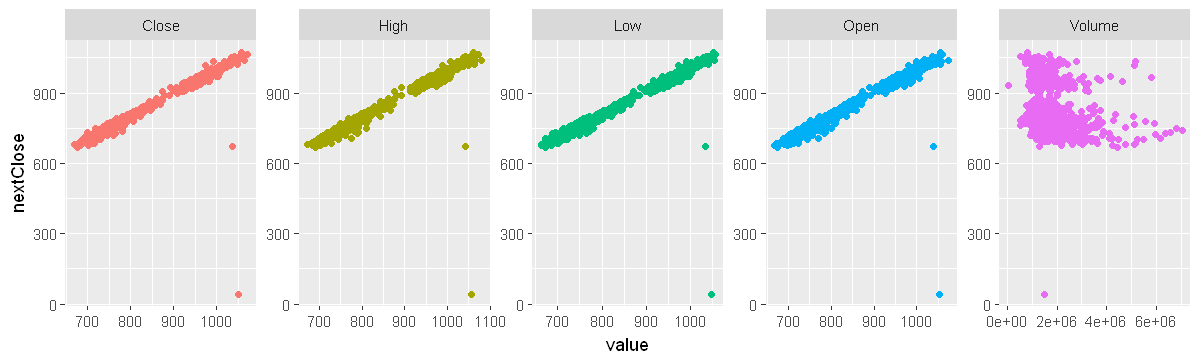

In [9]:
ggplot(stock_trading_data_tall) +
    aes(x=value, y = nextClose, color=var) +
    geom_point() +
    facet_wrap(~var, scales = 'free', ncol = 5) +
    theme(legend.position = 'none')

Almost perfect linear relation between price variables in adjacent open days for these two stocks!

### Research Questions and Prediction Objectives

1. What stocks (over all stocks or in each sector seperately) do have the similar trending during a certain period?

- What is the top 10 stocks which have the greastest increase or decrease during a certain period over all stocks or for each sector seperately?  

- What is the probability of rise or fall after continuously rising or falling for a certain amount of days? Consider it over all stocks, stocks in each sector , or several selected stocks seperately.

- After how many days of continously rising or falling is the probability of rise or fall highest?

- Predict next day's trend (rise or fall) using previous days' price and volume variables. Different day number and variables will be tried.

- Predict next day's price using previous days' features.

- Build a trading simulation to trade stocks using the best trained model (optional).

###  Plan

Analyses are conducted to answer each question.

1. For each stock, we have five features: `Close`, `High`, `Low`, `Open`, `Volume`. So the values of these feature construct a feature vector for a stock in one day. We are going to combine several days' data vector togother to form a long vector to represent a feature vector for a stock in several days. Then across all stocks or stocks in each sector, for a certain several days, a K-Mean clustering algorithm can be used to cluster stocks. Then stocks with similar trending may be grouped together.

2. For a cetain period, only considering the values of one of the features at the beginning and last day, the difference of the values can be used to rank stocks.

3. For a certain number of days, finding all the cases of continously rising (falling) in previous days, and rising or falling in the last day, then the probability of rise or fall can be computed by Bayesian formula.

4. Rank the probabilities obtained from question 3 for different number of days.

5. Combine data in the same way as did in question 1. For close price (either one of features can be used ), whether or not rise in the last day with respect to previous day is used as label. Then a binary classifier (like logistic classifier) can be used to classifier using all stocks' data or for stocks in each sector.

6. The same data processing as question 5, but a regression model is used to predict continous price.